In [20]:
from . import my_decoder_module as mdm

In [21]:
rfh = mdm.read_file("f:\\22 Code Playground\\Matrix PON Reverse Engineering\\Sound\\Global\\mono_test_file1")
start_offset = (16*4)
test_length = rfh['samples']
print("Reading {} bytes from {} byte".format(test_length, start_offset))
test = rfh['binary'][start_offset:start_offset+(test_length*16)]

Samples: 5724
Channels: 1
Samplerate: 18000
Length of read chunk: 5732
Reading 5724 bytes from 64 byte


Read 11448 values w/ bit factor = 4


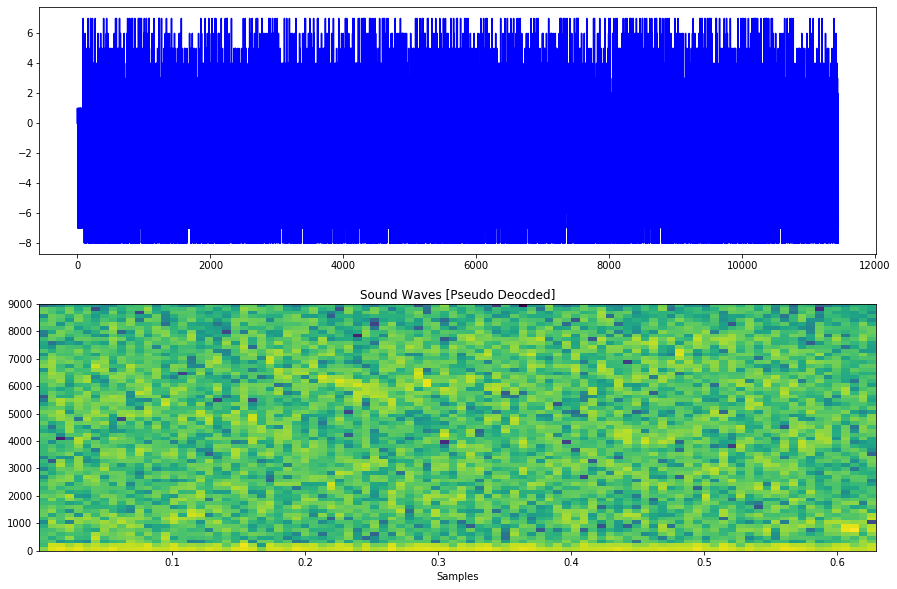

In [22]:
vtp = mdm.factorize(test, test_length)
mdm.plot(vtp, NFFT=128, Fs=18000, noverlap=10)

Read 5724 values w/ bit factor = 8


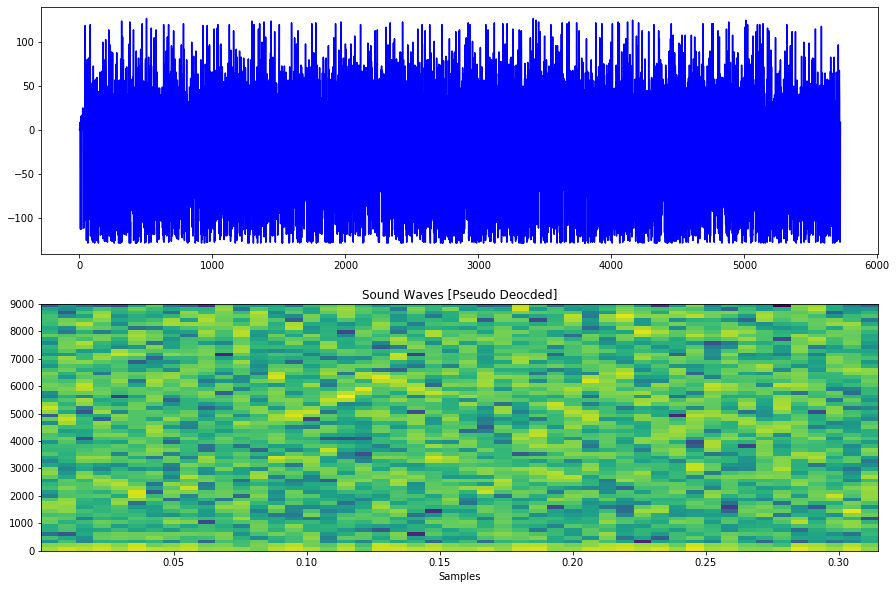

In [24]:
vtp = mdm.factorize(test, test_length, factor=8)
mdm.plot(vtp, NFFT=128, noverlap=10)

Read 22896 values w/ bit factor = 2


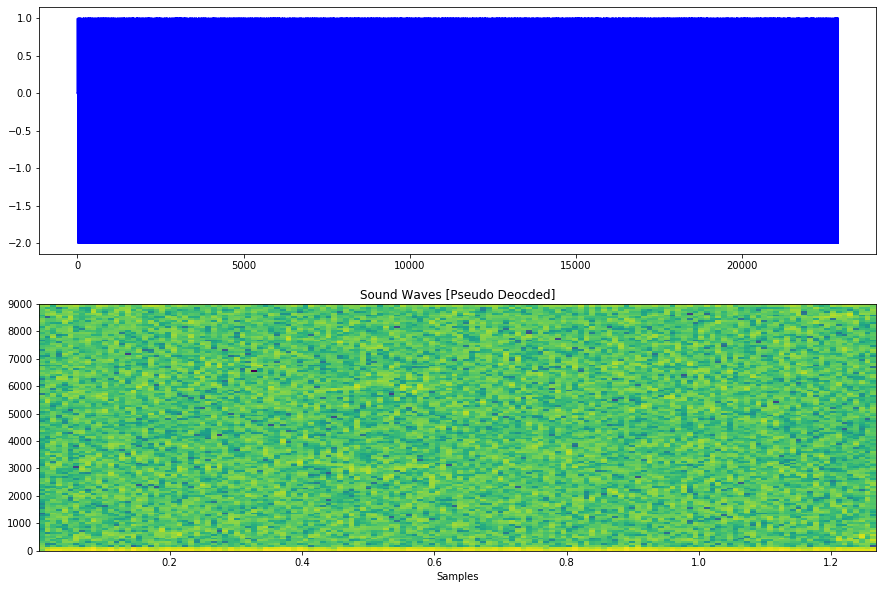

In [25]:
vtp = mdm.factorize(test, test_length, factor=2)
mdm.plot(vtp, NFFT=256, Fs=18000)

# ADPCM

In [26]:
index_table = [0xff, 0xff, 0xff, 0xff, 2, 4, 6, 8,
                0xff, 0xff, 0xff, 0xff, 2, 4, 6, 8]

step_size_table = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17,
19, 21, 23, 25, 28, 31, 34, 37, 41, 45,
50, 55, 60, 66, 73, 80, 88, 97, 107, 118,
130, 143, 157, 173, 190, 209, 230, 253, 279, 307,
337, 371, 408, 449, 494, 544, 598, 658, 724, 796,
876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066,
2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358,
5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899,
15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

In [28]:
x = 0
factor =8 
length = test_length
stream = test
ratio = mdm.BYTE_LENGTH / factor
new_values = []
while x < (length * ratio):
    new_values.append(stream[factor*x:factor*(x+1)])
    x += 1
# plot(vtp, NFFT=512, Fs=36000, noverlap=10)

In [29]:
state = { 'prevsample': 0, 'previndex': 0 }

In [30]:
def adpcm_decode(code):
    index = state['previndex']
    predsample = state['prevsample']
#     print("index: {}\npredsample: {}".format(index, predsample))

    step = step_size_table[state['previndex']]
#     print("Step: {}".format(step))

    diffq = step >> 3;
    if code.uint & 4:
        diffq += step;
    if code.uint & 2:
        diffq += step >> 1;
    if code.uint & 1:
        diffq += step >> 2;
#     print("diffq: {}".format(diffq))

    if( code.uint & 8 ):
        predsample -= diffq
    else:
        predsample += diffq

    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768

#     print("predsample (upd.): {}".format(predsample))

#     print("code: {}".format(code>>4))
    index += index_table[code[:4].int]
    if index < 0:
        index = 0
    if index > 88:
        index = 88
#     print("index (upd.): {}".format(index))

    state['prevsample'] = predsample;
    state['previndex'] = index;

    return predsample

In [31]:
state = { 'prevsample': 0, 'previndex': 0 }

res_array = []

for nv in new_values:
    a,b = nv[:4], nv[4:]
#     print("{} {}".format(a.bin, b.bin))
#     code = nv.int
    res_array.append(adpcm_decode(nv))

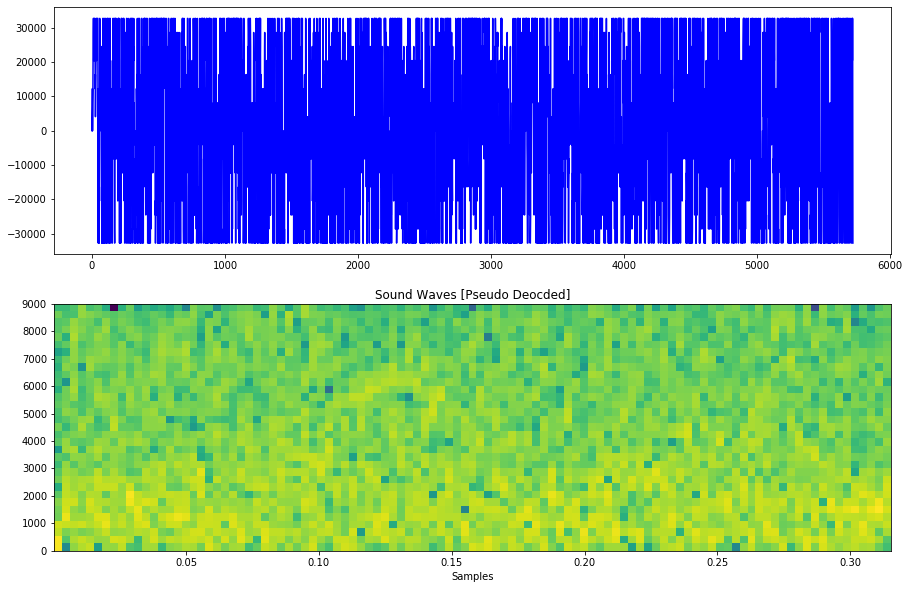

In [37]:
mdm.plot(res_array, NFFT=64, Fs=18000, noverlap=10)